

# Richards' Equation, steady state

### Changed the bottom Dirichlet BC to 240000 Pa - to have a saturated condition 

This is a simple verticle, pseudo-1D column of water with a water table below the surface.  It solves the pressure to steady-state.  For constant density and incompressible solid, this would be a linear pressure profile. (but we include a pressure-dependent density.)

Input parameters:

1. Mesh size defined using Generated Mesh - Box type.
- Low coordinate - (0,0,0), High coordinate - (1,1,10), number of cells - (1,1,100)
- Creates a pseudo 1D water column with 100 cells along the z-direction.

2. Solves the Richards equation

3. Boundary condition (Dirichlet type): Bottom surface - Pressure - 240000 Pa

4. Water Retention Parameters [WRM] - Van Genuchten Model : $alpha$ [$Pa^{-1}$] = 0.00015, m [-] = 0.8, residual saturation [-] = 0.

5. Water content is calculated by Richards water content. 

\begin{equation}
            \theta = n * s * \phi *  {cell volume}
\end{equation}

where n = = molar density of liquid phase [mol $m^{-3}$], s = saturation of phase [-], $\phi$ = porosity [-].

6. The relative permeability method - upwind with Darcy flux - Relative permeability is defined on cells, but must be calculated on faces to multiply a flux.

7. Porosity ($\phi$) = 0.25, permeability (K) = 2.5e-12 $m^2$, temperature (T) = 275.15 K, P_0 = atmospheric pressure (Pa)


### Richards equation:

For transient state, the 3-D Richard's equation in variably saturated domain is:
\begin{equation}
    \frac{\partial \theta}{\partial t} - \triangledown \frac{k_r n_l}{\mu} K (\triangledown p + \rho g \hat{z}) = Q_w 
\end{equation}

where, $\theta$ = Extensive water content of the cell [mol], t = time variable [s], $\triangledown$ = Divergence operator, $k_r$ = relative permeability [-], $n_l$ = molar density of liquid phase [mol $m^{-3}$], $\mu$ = Absolute (Dynamic) viscosity of water (Pas), K = Absolute permeability [$m^{2}$], p = liquid pressure [Pa], $\rho$ = density of water, $\hat{z}$ = elevation [m], $Q_w$ = mass source of water [mol $s^{-1}$] 

For steady state, $\frac{\partial \theta}{\partial t}$ = 0 and no source or sink term, implies that $Q_w$ = 0.

Hence the above equation reduces as:
\begin{equation}
    \triangledown \frac{k_r n_l}{\mu} K (\triangledown p + \rho g \hat{z}) = 0
\end{equation}

### Van Genuchten Model:

Defined in the function - $wrm_{vangenuchten}$

The retention curve as given by [Schuh et al., 2017]: (Is this the same equation that the demo problem executes?)

If $P_c$ > 0,
\begin{equation}
     S_* (P_c) = S_r + (1 - S_r) [1 + (\alpha P_c)^n]^{-m}
\end{equation}

else 
\begin{equation}
    S_* (P_c) = 1
\end{equation}

Combined with the Mualem (1976) model for re-scaling liquid phase permeability:
\begin{equation}
    k_{r1} = (s_l)^{0.5}[1 - (1 - (s_l)^{\frac{1}{m}})^{m}]^{2}
\end{equation}

where, $S_r$ (-) - Residual saturation, $P_c$ (Pa) - Capillary pressure, and $\alpha$ ($Pa^{-1}$), and m = 1 - 1/n - model parameters, $s_l$ = saturation of liquid

The exponent m controls the shape of the soil retention curve and can be related to the pore size distribution of the texture, where larger values corresponds to smaller pore size variability i.e. to well-sorted textures. 



Author: Ethan Coon (Initial code) and Radhakrishna

In [1]:
%matplotlib inline

In [2]:
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
import ats_xdmf
import plot_column_data
import numpy as np
from matplotlib import pyplot as plt
import h5py
import pandas as pd

In [3]:
import warnings

warnings.filterwarnings('ignore')

In [4]:
# load the ATS solution
directory = "./richards_steadstate_ss.demo"
vis = ats_xdmf.VisFile(directory)
vis.loadMesh(columnar=True)


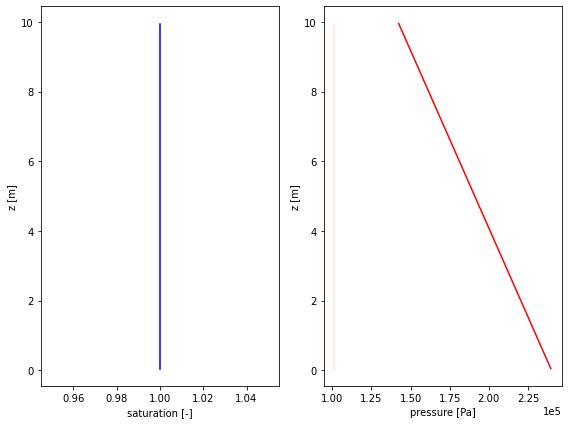

In [5]:
# plot the solution
fig = plt.figure(figsize=(8,6))
axs = fig.subplots(1,2)
plot_column_data.plot_subsurface(vis, ['saturation_liquid',], axs[0], None, 'b')
plot_column_data.plot_subsurface(vis, ['pressure',], axs[1], None, 'r')
axs[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axs[0].set_xlabel('saturation [-]')
axs[0].set_ylabel('z [m]')
axs[1].set_xlabel('pressure [Pa]')
axs[1].set_ylabel('z [m]')
plt.tight_layout()
plt.show()

VGC parameters: alpha = 0.00015, m = 0.8

* Q - What is the equation describing this linear behaviour? - 
* Hydraulic head = Pressure head + Elevation head
* As z increases, Pressure head decreases (since hydraulic head remains constant) - Since it is a variably saturated zone, doesnt the pressure head also decrease as matric potential decreases as z increases from bottom? - The solution of pressure is the absolute pressure = water pressure + atmospheric pressure

$P_{abs} = P_l + P_o$

Q - What is the relationship between the atmospheric pressure at the boundary surface and the water pressure within the system?

In [6]:
### Moles to kg for water
# molar_mass_water = 18.015 # g/mol
# Assume 50 moles - how much grams does it weigh?
#water_moles = 50
#water_mass = 18.015 * 50
#water_mass

In [7]:
# The file is always stored as /0 (at initial instance) or /1 (at time instance 1)

# Printing all the quantities at time instance = 0
print('Printing all the quantities at initial instance = 0 \n')
print('Values are assigned for each of the 100 cells \n')
print('U - User, D - Developer \n')

with h5py.File('richards_steadstate_ss.demo/ats_vis_data.h5','r') as hdf:
    ls = list(hdf.keys())
    print('List of datasets in this file: \n \n', ls)
    print('\n')
    
    cell_volume_all_0 = np.array(hdf.get('cell_volume.cell.0/0'))
    cell_volume_0 = np.unique(cell_volume_all_0.flatten())
    print('Cell volume = ', cell_volume_0[0],'m^3 (U)') # Why 0.1 multiple times?
    print('\n')
    
    mass_density_all_0 = np.array(hdf.get('mass_density_liquid.cell.0/0'))
    mass_density_0 = np.unique(mass_density_all_0.flatten())
    print('Mass density [rho_w] = ',mass_density_0, 'kg m^{-3} (D)') # Assigned by developer
    print('\n')
    
    molar_density_all_0 = np.array(hdf.get('molar_density_liquid.cell.0/0'))
    molar_density_0 = np.unique(molar_density_all_0.flatten())
    print('Molar density of water [n_l] = ',molar_density_0, 'mol m^{-3} (D)') # Assigned by developer
    print('\n')
    
    permeability_all_0 = np.array(hdf.get('permeability.cell.0/0'))
    permeability_0 = np.unique(permeability_all_0.flatten())
    print('Absolute permeability [K] = ',permeability_0, ' m^{2} (U)') # Assigned by user
    print('\n')
    
    porosity_all_0 = np.array(hdf.get('porosity.cell.0/0'))
    porosity_0 = np.unique(porosity_all_0.flatten())
    print('Porosity [phi] = ',porosity_0, ' [-] (U)') # Assigned by user
    print('\n')
    
    pressure_all_0 = np.array(hdf.get('pressure.cell.0/0'))
    pressure_0 = np.unique(pressure_all_0.flatten())
    print('Absolute pressure [p_abs] = ',pressure_0, ' [Pa] (U)') # Assigned by user
    print('\n')
    
    relative_permeability_all_0 = np.array(hdf.get('relative_permeability.cell.0/0'))
    relative_permeability_0 = np.unique(relative_permeability_all_0.flatten())
    print('Relative permeability (Calculated by upwind with Darcy flux) [kr] = ',relative_permeability_0, ' [-] (U)') # Assigned by user with a method
    print('\n')
    
    saturation_gas_all_0 = np.array(hdf.get('saturation_gas.cell.0/0'))
    saturation_gas_0 = np.unique(saturation_gas_all_0.flatten())
    print('Saturation of gas [s_g] = ',saturation_gas_0, ' [-] (D)') # Assigned by DEVELOPER
    print('\n')
    
    saturation_liquid_all_0 = np.array(hdf.get('saturation_liquid.cell.0/0'))
    saturation_liquid_0 = np.unique(saturation_liquid_all_0.flatten())
    print('Saturation of liquid [s_l] = ',saturation_liquid_0, ' [-] (D)- Fully saturated') # Assigned by DEVELOPER
    print('\n')
    
    temperature_all_0 = np.array(hdf.get('temperature.cell.0/0'))
    temperature_0 = np.unique(temperature_all_0.flatten())
    print('Temperature [T] (at boundary faces and cells?) = ',temperature_0, ' [K] (U)') # Assigned by user
    print('\n')
    
    viscosity_liquid_all_0 = np.array(hdf.get('viscosity_liquid.cell.0/0'))
    viscosity_liquid_0 = np.unique(viscosity_liquid_all_0.flatten())
    print('dynamic_viscosity_liquid [v] = ',viscosity_liquid_0, ' [Pas] (D)') # Assigned by user
    print('\n')
    
    water_content_all_0 = np.array(hdf.get('water_content.cell.0/0'))
    water_content_0 = np.unique(water_content_all_0.flatten())
    print('water_content [theta] = ',water_content_0[0], ' [mol] (U & D)') # Assigned by user through Richards water content
    ### Moles to kg for water
    molar_mass_water = 18.015 # g/mol
    water_mass = 18.015 * 50
    print('\n')
    print('water_content [theta] = ',water_content_0[0]*molar_mass_water/1000, ' [Kg] (U)') 
    print('\n')
    print('richards_water_content [theta = phi*s*n_l*cellvolume] = ',porosity_0*saturation_liquid_0*molar_density_0*cell_volume_0[0], ' [mol] (U & D)')
    water_mass
    print('\n')
    
    

Printing all the quantities at initial instance = 0 

Values are assigned for each of the 100 cells 

U - User, D - Developer 

List of datasets in this file: 
 
 ['capillary_pressure_gas_liq.cell.0', 'cell_volume.cell.0', 'darcy_velocity.cell.0', 'darcy_velocity.cell.1', 'darcy_velocity.cell.2', 'mass_density_liquid.cell.0', 'molar_density_liquid.cell.0', 'permeability.cell.0', 'porosity.cell.0', 'pressure.cell.0', 'relative_permeability.cell.0', 'saturation_gas.cell.0', 'saturation_liquid.cell.0', 'temperature.cell.0', 'viscosity_liquid.cell.0', 'water_content.cell.0']


Cell volume =  0.09999999999999964 m^3 (U)


Mass density [rho_w] =  [999.96028211] kg m^{-3} (D)


Molar density of water [n_l] =  [55506.16876284] mol m^{-3} (D)


Absolute permeability [K] =  [2.5e-12]  m^{2} (U)


Porosity [phi] =  [0.25]  [-] (U)


Absolute pressure [p_abs] =  [101325.]  [Pa] (U)


Relative permeability (Calculated by upwind with Darcy flux) [kr] =  [3.32744356]  [-] (U)


Saturation of gas [s_g

* Express water content as a dimensionless number? Similar to saturation!

### Storing the parameters as dataframes

In [8]:
# The file is always stored as /0 (at initial instance) or /1 (at time instance 1)

# Printing all the quantities at time instance = 0
print('Storing all the quantities at initial instance = 1 \n')
print('Values are assigned for each of the 100 cells \n')
print('U - User, D - Developer \n')

with h5py.File('richards_steadstate_ss.demo/ats_vis_data.h5','r') as hdf:
    ls = list(hdf.keys())
    print('List of datasets in this file: \n \n', ls)
    print('\n')
    
    # Cell_volume
    cell_volume_all = np.array(hdf.get('cell_volume.cell.0/1'))
    cell_volume = cell_volume_all.flatten()
    
    # Storing the variables/constants in a dataframe - Do we have a direct function to do this? 
    # Can we simplify the code?
    z = np.arange(0.0,10.0,0.1)
    data_results = pd.DataFrame(index=z,data=cell_volume,columns=['cell_volume'])

    mass_density_all = np.array(hdf.get('mass_density_liquid.cell.0/1'))
    mass_density = mass_density_all.flatten()
    data_results['mass_density [rho_l] [kg m^{-3}]'] = mass_density


    
    molar_density_all = np.array(hdf.get('molar_density_liquid.cell.0/1'))
    molar_density = molar_density_all.flatten()
    data_results['molar_density [n_l] [mol m^{-3}]'] = molar_density

    
    permeability_all = np.array(hdf.get('permeability.cell.0/1'))
    permeability = permeability_all.flatten()
    data_results['Absolute permeability [K] (m^{2})'] = permeability

    
    
    porosity_all = np.array(hdf.get('porosity.cell.0/1'))
    porosity = porosity_all.flatten()
    data_results['Porosity [phi] (-)'] = porosity

    pressure_all = np.array(hdf.get('pressure.cell.0/1'))
    pressure = pressure_all.flatten()
    data_results['Abs pressure [p_abs] [Pa]'] = pressure 
    # Water pressure or total pressure (Atm + water)? - Probably both
    
    relative_permeability_all = np.array(hdf.get('relative_permeability.cell.0/1'))
    relative_permeability = relative_permeability_all.flatten()
    data_results['Relative permeability [kr] [-]'] = relative_permeability

    
    saturation_gas_all = np.array(hdf.get('saturation_gas.cell.0/1'))
    saturation_gas = saturation_gas_all.flatten()
    data_results['Saturation of gas [s_g] [-]'] = saturation_gas

    
    saturation_liquid_all = np.array(hdf.get('saturation_liquid.cell.0/1'))
    saturation_liquid = saturation_liquid_all.flatten()
    data_results['Saturation of liquid [s_l] [-]'] = saturation_liquid

    
    temperature_all = np.array(hdf.get('temperature.cell.0/1'))
    temperature = temperature_all.flatten()
    data_results['Temperature [T] [K]'] = temperature

    
    viscosity_liquid_all = np.array(hdf.get('viscosity_liquid.cell.0/1'))
    viscosity_liquid = viscosity_liquid_all.flatten()
    data_results['viscosity_liquid [v] Pas]'] = viscosity_liquid

    
    water_content_all = np.array(hdf.get('water_content.cell.0/1'))
    water_content = water_content_all.flatten()
    data_results['water_content [theta] mols'] = water_content

data_results
    

Storing all the quantities at initial instance = 1 

Values are assigned for each of the 100 cells 

U - User, D - Developer 

List of datasets in this file: 
 
 ['capillary_pressure_gas_liq.cell.0', 'cell_volume.cell.0', 'darcy_velocity.cell.0', 'darcy_velocity.cell.1', 'darcy_velocity.cell.2', 'mass_density_liquid.cell.0', 'molar_density_liquid.cell.0', 'permeability.cell.0', 'porosity.cell.0', 'pressure.cell.0', 'relative_permeability.cell.0', 'saturation_gas.cell.0', 'saturation_liquid.cell.0', 'temperature.cell.0', 'viscosity_liquid.cell.0', 'water_content.cell.0']




,cell_volume,mass_density [rho_l] [kg m^{-3}],molar_density [n_l] [mol m^{-3}],Absolute permeability [K] (m^{2}),Porosity [phi] (-),Abs pressure [p_abs] [Pa],Relative permeability [kr] [-],Saturation of gas [s_g] [-],Saturation of liquid [s_l] [-],Temperature [T] [K],viscosity_liquid [v] Pas],water_content [theta] mols
0.0,0.1,1000.029372,55510.003811,2.500000e-12,0.25,239509.653100,3.327673,0.0,1.0,275.15,0.001668,1387.750095
0.1,0.1,1000.028881,55509.976593,2.500000e-12,0.25,238528.959539,3.327672,0.0,1.0,275.15,0.001668,1387.749415
0.2,0.1,1000.028391,55509.949376,2.500000e-12,0.25,237548.266460,3.327670,0.0,1.0,275.15,0.001668,1387.748734
0.3,0.1,1000.027901,55509.922159,2.500000e-12,0.25,236567.573862,3.327669,0.0,1.0,275.15,0.001668,1387.748054
0.4,0.1,1000.027410,55509.894942,2.500000e-12,0.25,235586.881744,3.327667,0.0,1.0,275.15,0.001668,1387.747374
...,...,...,...,...,...,...,...,...,...,...,...,...
9.5,0.1,999.982792,55507.418231,2.500000e-12,0.25,146345.911669,3.327518,0.0,1.0,275.15,0.001668,1387.685456
9.6,0.1,999.982301,55507.391015,2.500000e-12,0.25,145365.263784,3.327517,0.0,1.0,275.15,0.001668,1387.684775
9.7,0.1,999.981811,55507.363799,2.500000e-12,0.25,144384.616381,3.327515,0.0,1.0,275.15,0.001668,1387.684095
9.8,0.1,999.981321,55507.336583,2.500000e-12,0.25,143403.969459,3.327514,0.0,1.0,275.15,0.001668,1387.683415


## Plotting the parameters

Why is pressure and density dependent? - Related based on saturation?

Given by the equation -

$P_l = \rho_w g h$

In [9]:
data_results['mass_density [rho_l] [kg m^{-3}]'].describe()

count     100.000000
mean     1000.005101
std         0.014225
min       999.980830
25%       999.992966
50%      1000.005101
75%      1000.017236
max      1000.029372
Name: mass_density [rho_l] [kg m^{-3}], dtype: float64

### Plotting the pressure:

Assume $p_0$ - atmospheric pressure, $p_l$ - water pressure, $p_z$ = elevation pressure, $p_h$ = hydraulic pressure, $p_{abs}$ = Absolute pressure 

$p_{abs}$ - Piezometers measure absolute pressure

$p_{abs} = p_{0} + p_{l}$

$p_h = p_l + p_z$ 

The elevation where -ve water pressure develops, is the elevation where the saturation starts to drops from 1.

Here, the resultant pressure from the model is the absolute pressure (and not the water pressure! - right?)

In [10]:
rho_avg = np.mean(mass_density) # kg m^{-3} - Provided by the developer 
g = 9.8006 # ms^{-2} - Provided by the user, g = (0,0,-9.8006m ms^{-2})
p_0 = 101325 # Pa

# Calculating the water pressure = p_abs -p_0
data_results['Water pressure [p_l] [Pa]'] = data_results['Abs pressure [p_abs] [Pa]'] - p_0

data_results['Pressure head [m]'] = data_results['Water pressure [p_l] [Pa]']/(rho_avg*g)

data_results['Elevation head [m]'] = data_results.index

data_results['Hydraulic head [m]'] = data_results['Pressure head [m]'] + data_results['Elevation head [m]']

data_results['Atmospheric pressure head [m]'] = 101325/(rho_avg*g)

data_results

,cell_volume,mass_density [rho_l] [kg m^{-3}],molar_density [n_l] [mol m^{-3}],Absolute permeability [K] (m^{2}),Porosity [phi] (-),Abs pressure [p_abs] [Pa],Relative permeability [kr] [-],Saturation of gas [s_g] [-],Saturation of liquid [s_l] [-],Temperature [T] [K],viscosity_liquid [v] Pas],water_content [theta] mols,Water pressure [p_l] [Pa],Pressure head [m],Elevation head [m],Hydraulic head [m],Atmospheric pressure head [m]
0.0,0.1,1000.029372,55510.003811,2.500000e-12,0.25,239509.653100,3.327673,0.0,1.0,275.15,0.001668,1387.750095,138184.653100,14.099540,0.0,14.099540,10.3386
0.1,0.1,1000.028881,55509.976593,2.500000e-12,0.25,238528.959539,3.327672,0.0,1.0,275.15,0.001668,1387.749415,137203.959539,13.999476,0.1,14.099476,10.3386
0.2,0.1,1000.028391,55509.949376,2.500000e-12,0.25,237548.266460,3.327670,0.0,1.0,275.15,0.001668,1387.748734,136223.266460,13.899411,0.2,14.099411,10.3386
0.3,0.1,1000.027901,55509.922159,2.500000e-12,0.25,236567.573862,3.327669,0.0,1.0,275.15,0.001668,1387.748054,135242.573862,13.799347,0.3,14.099347,10.3386
0.4,0.1,1000.027410,55509.894942,2.500000e-12,0.25,235586.881744,3.327667,0.0,1.0,275.15,0.001668,1387.747374,134261.881744,13.699283,0.4,14.099283,10.3386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.5,0.1,999.982792,55507.418231,2.500000e-12,0.25,146345.911669,3.327518,0.0,1.0,275.15,0.001668,1387.685456,45020.911669,4.593666,9.5,14.093666,10.3386
9.6,0.1,999.982301,55507.391015,2.500000e-12,0.25,145365.263784,3.327517,0.0,1.0,275.15,0.001668,1387.684775,44040.263784,4.493606,9.6,14.093606,10.3386
9.7,0.1,999.981811,55507.363799,2.500000e-12,0.25,144384.616381,3.327515,0.0,1.0,275.15,0.001668,1387.684095,43059.616381,4.393547,9.7,14.093547,10.3386
9.8,0.1,999.981321,55507.336583,2.500000e-12,0.25,143403.969459,3.327514,0.0,1.0,275.15,0.001668,1387.683415,42078.969459,4.293488,9.8,14.093488,10.3386


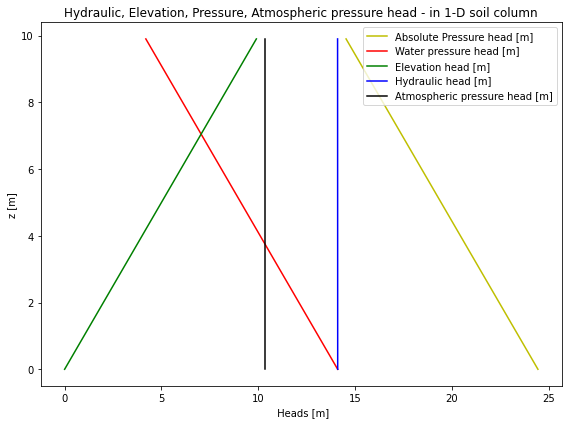

In [11]:
# To find the elevation where -ve pressure head begins
#z_drop = data_results[data_results['Pressure head [m]'].le(0)].index[0]

 
fig = plt.figure(figsize=(8,6))

plt.title('Hydraulic, Elevation, Pressure, Atmospheric pressure head - in 1-D soil column')
plt.plot(data_results['Abs pressure [p_abs] [Pa]']/(rho_avg*g), z, 'y', label='Absolute Pressure head [m]')
plt.plot(data_results['Pressure head [m]'], z, 'r', label='Water pressure head [m]')
plt.plot(data_results['Elevation head [m]'], z, 'g', label='Elevation head [m]')
plt.plot(data_results['Hydraulic head [m]'], z, 'b', label='Hydraulic head [m]')
plt.plot(data_results['Atmospheric pressure head [m]'], z, 'k', label='Atmospheric pressure head [m]')
#plt.axhline(y=z_drop,color='k',linestyle='--',label='z_drop = 3.9 m')
plt.ylabel('z [m]')
plt.xlabel(' Heads [m]')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# Density dependent pressure or pressure dependent density?
# fig = plt.figure(figsize=(8,6))

#plt.title('Pressure dependent density')
#plt.plot(data_results['Pressure head [m]'], data_results['mass_density [rho_l] [kg m^{-3}]'], 'r')

#plt.xlabel('Pressure head [m]')
#plt.ylabel(' Mass density [kg m^{-3}]')
#plt.tight_layout()
#plt.show()

### Plotting relative permeability

In [13]:
data_results.columns

Index(['cell_volume', 'mass_density [rho_l] [kg m^{-3}]',
       'molar_density [n_l] [mol m^{-3}]', 'Absolute permeability [K] (m^{2})',
       'Porosity [phi] (-)', 'Abs pressure [p_abs] [Pa]',
       'Relative permeability [kr] [-]', 'Saturation of gas [s_g] [-]',
       'Saturation of liquid [s_l] [-]', 'Temperature [T] [K]',
       'viscosity_liquid [v] Pas]', 'water_content [theta] mols',
       'Water pressure [p_l] [Pa]', 'Pressure head [m]', 'Elevation head [m]',
       'Hydraulic head [m]', 'Atmospheric pressure head [m]'],
      dtype='object')

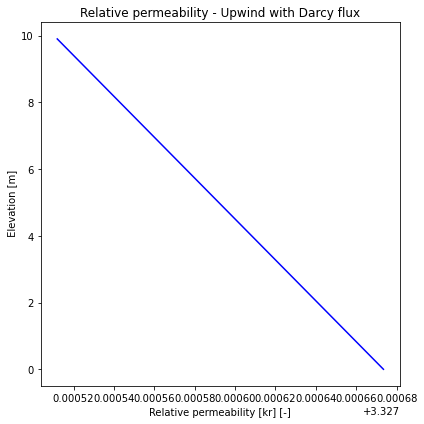

In [14]:
fig = plt.figure(figsize=(6,6))

plt.title('Relative permeability - Upwind with Darcy flux')
plt.plot(data_results['Relative permeability [kr] [-]'],z, 'b')

plt.xlabel('Relative permeability [kr] [-]')
plt.ylabel(' Elevation [m]')
plt.tight_layout()
#plt.show()

- How is the relative permeability calculated? - Van Genuchten Maulem model

### Van-Genuchten Maulem  Model

#### Defined in the function - $wrm_{vangenuchten}$

The retention curve as given by [Schuh et al., 2017] :

If $P_c$ > 0, $S_*$ ($P_c$) = $S_r$ + (1 - $S_r$) $[1 + (\alpha P_c)^n]^{-m}$

else $S_*$ ($P_c$) = 1


Combined with the Mualem (1976) model for re-scaling liquid phase permeability:
\begin{equation}
    k_{r1} = (s_l)^{0.5}[1 - (1 - (s_l)^{\frac{1}{m}})^{m}]^{2}
\end{equation}

where, $S_*$ - Retention curve for unfrozen liquid-gas phase, $S_r$ (-) - Residual saturation, $P_c$ (Pa) - Capillary pressure, and $\alpha$ ($Pa^{-1}$), and m = 1 - 1/n - model parameters, $s_l$ = saturation of liquid

The saturation of liquid and gas is equal to 1, i.e,

$s_l + s_g = 1$






The exponent m controls the shape of the soil retention curve and can be related to the pore size distribution of the texture, where larger values corresponds to smaller pore size variability i.e. to well-sorted textures.

Combined with the Mualem (1976) model for re-scaling liquid phase permeability:
\begin{equation}
    k_{r1} = (s_l)^{0.5}[1 - (1 - (s_l)^{\frac{1}{m}})^{m}]^{2}
\end{equation}

$s_l = S_* [-\beta \rho_i h_0 \upsilon H (-\upsilon) + (S_*)^{-1} (s_l + s_i)]$

Q - How is saturation of liquid calculated? - Is this the same equation used in the demo problem?

#### Calculating the saturation based on VanGenuchten's model


In [15]:
# data_results_VGC = pd.DataFrame(data=data_results['Water pressure [p] [Pa]'].values,index=

In [16]:
#data_results_VGC['ad'] = data_results['Water pressure [p] [Pa]']*10

In [17]:
##### Parameters that we assigned:
#alpha = 0.00015
#m = 0.8
#Sr = 0
#n = 1/(1-m)
#data_results_VGC = data_results.copy()
#data_results_VGC['S_*'] = Sr + (1 - Sr) * pow(1 + pow(alpha*data_results_VGC['Water pressure [p] [Pa]'],n),(-m))
#data_results_VGC['S_*(Pc)'] =  pow(1 + pow(alpha * data_results['Water pressure [p] [Pa]'],n),(-m))


How do you find out saturation of the liquid?

### Plotting saturation :

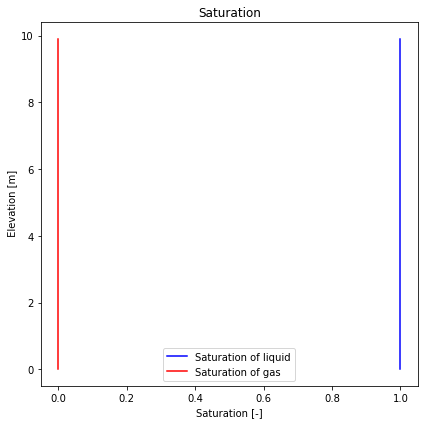

In [18]:
fig = plt.figure(figsize=(6,6))

plt.title('Saturation')
plt.plot(data_results['Saturation of liquid [s_l] [-]'], z, 'b', label='Saturation of liquid')
plt.plot(data_results['Saturation of gas [s_g] [-]'], z, 'r', label='Saturation of gas')

plt.xlabel('Saturation [-]')
plt.ylabel(' Elevation [m]')
plt.tight_layout()
plt.legend()
#plt.show()

In [274]:
### Plotting Richards water content

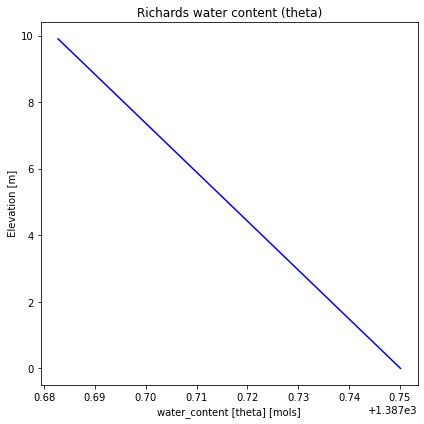

In [19]:
fig = plt.figure(figsize=(6,6))

plt.title('Richards water content (theta)')
plt.plot(data_results['water_content [theta] mols'],z, 'b')

plt.xlabel('water_content [theta] [mols]')
plt.ylabel(' Elevation [m]')
plt.tight_layout()
#plt.show()

### Plotting

In [270]:
data_results.columns

Index(['cell_volume', 'mass_density [rho_l] [kg m^{-3}]',
       'molar_density [n_l] [mol m^{-3}]', 'Absolute permeability [K] (m^{2})',
       'Porosity [phi] (-)', 'Water pressure [p] [Pa]',
       'Relative permeability [kr] [-]', 'Saturation of gas [s_g] [-]',
       'Saturation of liquid [s_l] [-]', 'Temperature [T] [K]',
       'viscosity_liquid [v] Pas]', 'water_content [theta] mols',
       'Pressure head [m]', 'Elevation head [m]', 'Hydraulic head [m]',
       'Atmospheric pressure head [m]'],
      dtype='object')